Drugs Reviews Sentiment Analysis

Problem statement

The aim of this project is to compare different text representations and learning models in the context of a classification task.


The dataset that we will use is the Drug Reviews Dataset.


We will understand and clean data by performing some Exploratory Data Analysis (EDA) and Text Preprocessing.


Since the dataset does not provide a sentiment target variable, we will label the reviews using two different strategies:

Ratings
VADER
We will use three different models:

CountVectorizer (BoW)
TF-IDF
Dense Word Embedding (Glove)
For each of them we will try three different algorithms for classification:

Naive Bayes
Logistic Regression
Random Forest
For some of these configurations we will run a GridSearch to find the best hyper parameters.

For each model, we are going to calculate the 
 confidence interval on accuracy.

Finally, we are going to compare our models in pairs through the significance test to determine if there is a model which can be considered better than the others; in particular, we will compare the performance of the best models found through the various grid searches by statistically compared the accuracy on the test set.

In the "Final Considerations" section we will report a summary of the results obtained and some considerations on them.

NOTES

Some sections may take a long time to run.

Therefore, in this folder you can find the files to load during the execution; in particular:

*df.p* to skip the "Data Understanding", "Text Preprocessing" and "Labeling" sections, and go directly to "Models -> Load Clean Dataset".
*X_train.p, X_test.p, Y_train.p, Y_test.p* to skip the preparation part of the embedding matrix and data in the "Dense Word Embedding" section and go directly to "Dense Word Embedding -> Load Input Data".
Configuration
We import all the required packages.

In [1]:
pip install vaderSentiment 


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install contractions

Defaulting to user installation because normal site-packages is not writeable


In [3]:
pip install pyspellchecker

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [4]:
# Utility
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy
import math
%matplotlib inline
from matplotlib import style
style.use('ggplot')
import os 
import pickle 
from time import time
import random

# Extra tools for data preprocessing 
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
import re
from functools import reduce
from nltk.stem.snowball import SnowballStemmer
from collections import OrderedDict


# Vader 
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Downloader for Glove Word Embedding 
import gensim
import gensim.downloader as gloader

# WordCloud
from wordcloud import WordCloud, STOPWORDS

# Contractions
import contractions

# Sklearn 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split 
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.naive_bayes import MultinomialNB 
from sklearn.ensemble import RandomForestClassifier  
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import pickle


[nltk_data] Error loading stopwords: <urlopen error [WinError 10060] A
[nltk_data]     connection attempt failed because the connected party
[nltk_data]     did not properly respond after a period of time, or
[nltk_data]     established connection failed because connected host
[nltk_data]     has failed to respond>
[nltk_data] Error loading punkt: <urlopen error [WinError 10060] A
[nltk_data]     connection attempt failed because the connected party
[nltk_data]     did not properly respond after a period of time, or
[nltk_data]     established connection failed because connected host
[nltk_data]     has failed to respond>


#read your csv file

In [5]:
#read File
df = pd.read_csv('drug_data.csv',encoding='latin-1')
df.head()
# read first 5 records

,UniqueID,drugName,condition,review,rating,date,usefulCount
0,75612,L-methylfolate,depression,"""I have taken anti-depressants for years, with...",10.0,2017-03-09,54
1,96233,Sertraline,depression,"""1 week on Zoloft for anxiety and mood swings....",8.0,2011-05-07,3
2,121333,Venlafaxine,depression,"""my gp started me on Venlafaxine yesterday to ...",4.0,2016-04-27,3
3,156544,Dulaglutide,"diabetes, type 2","""Hey Guys, It&#039;s been 4 months since my l...",10.0,2017-10-24,24
4,131909,Effexor XR,depression,"""This medicine saved my life. I was at my wits...",10.0,2013-06-20,166


In [6]:
# # read last 5 records
df.tail()

,UniqueID,drugName,condition,review,rating,date,usefulCount
13939,198130,Metoprolol,high blood pressure,"""It is fourth blood pressure pill for me. It f...",4.0,2009-07-15,39
13940,34443,Bystolic,high blood pressure,"""While on Bystolic my feet and arms were numb....",1.0,2009-07-18,25
13941,86533,Invokana,"diabetes, type 2","""I just got diagnosed with type 2. My doctor p...",9.0,2015-10-23,47
13942,93069,Vortioxetine,depression,"""This is the third med I&#039;ve tried for anx...",2.0,2016-07-17,33
13943,103458,Tekturna,high blood pressure,"""I have only been on Tekturna for 9 days. The ...",7.0,2010-02-07,18


# Understanding the data

In [7]:
df.shape

(13944, 7)

In [8]:
# check columns in dataset
df.columns

Index(['UniqueID', 'drugName', 'condition', 'review', 'rating', 'date',
       'usefulCount'],
      dtype='object')

In [9]:
# Convert date to datetime 
df['date'] = pd.to_datetime(df['date'])  

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13944 entries, 0 to 13943
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   UniqueID     13944 non-null  int64         
 1   drugName     13944 non-null  object        
 2   condition    13944 non-null  object        
 3   review       13944 non-null  object        
 4   rating       13944 non-null  float64       
 5   date         13944 non-null  datetime64[ns]
 6   usefulCount  13944 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 762.7+ KB


In [11]:
# checking duplicate values 
df.duplicated().sum()

0

In [12]:
#check null values in dataset
df.isnull().sum()

UniqueID       0
drugName       0
condition      0
review         0
rating         0
date           0
usefulCount    0
dtype: int64

In [13]:
df.shape

(13944, 7)

In [14]:
# renaming the unknown  column to UniqueID
df= df.rename({'Unnamed: 0': 'UniqueID'}, axis=1)

In [15]:
# statistical values for all column
df.describe(include= 'all')

C:\Users\Admin\AppData\Local\Temp\ipykernel_16576\3949848010.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(include= 'all')


,UniqueID,drugName,condition,review,rating,date,usefulCount
count,13944.000000,13944,13944,13944,13944.000000,13944,13944.000000
unique,NaN,334,3,9802,NaN,3138,NaN
top,NaN,Bupropion,depression,"""I have suffered from severe depression/anxiet...",NaN,2016-03-03 00:00:00,NaN
freq,NaN,549,9069,3,NaN,24,NaN
first,NaN,NaN,NaN,NaN,NaN,2008-02-25 00:00:00,NaN
last,NaN,NaN,NaN,NaN,NaN,2017-12-12 00:00:00,NaN
mean,125186.191050,NaN,NaN,NaN,6.862952,NaN,45.737880
std,64495.952023,NaN,NaN,NaN,3.207061,NaN,51.782627
min,870.000000,NaN,NaN,NaN,1.000000,NaN,0.000000
25%,74605.750000,NaN,NaN,NaN,4.000000,NaN,16.000000


Top condition is Birth Control.
Top review is just a single word "Good", but it has very small count - 39. May be lazy people like me have written that comment.
Most single day review came on 1-Mar-16, it will be interesting to investigate this date and see for which drugName and which conditions these reviews were for.

In [16]:
#check number of unique values in drugName
df['drugName'].nunique()


334

In [17]:
#check number of unique values in condition
df['condition'].nunique()

3

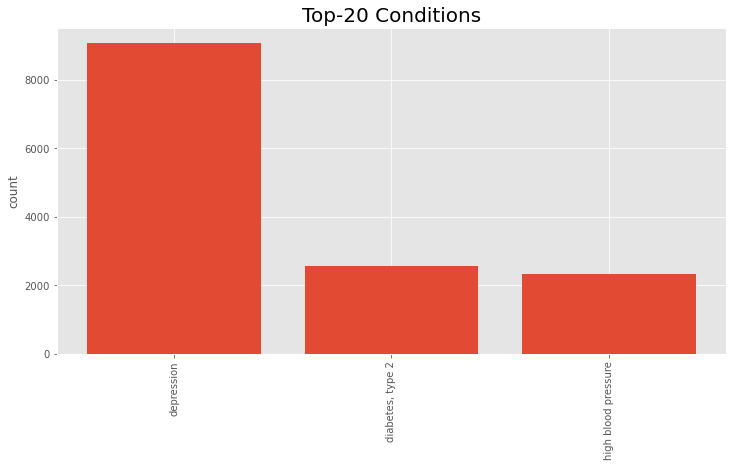

In [18]:
# plot a bargraph to check top 20 conditions
plt.figure(figsize=(12,6))
conditions = df['condition'].value_counts(ascending = False).head(20)

plt.bar(conditions.index,conditions.values)
plt.title('Top-20 Conditions',fontsize = 20)
plt.xticks(rotation=90)
plt.ylabel('count')
plt.show()

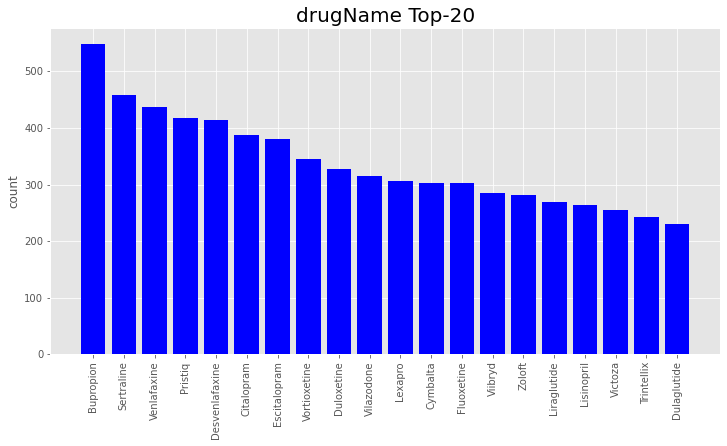

In [19]:
#plot a bargraph to check top 20 drugName
plt.figure(figsize=(12,6))
drugName_top = df['drugName'].value_counts(ascending = False).head(20)

plt.bar(drugName_top.index,drugName_top.values,color='blue')
plt.title('drugName Top-20',fontsize = 20)
plt.xticks(rotation=90)
plt.ylabel('count')
plt.show()

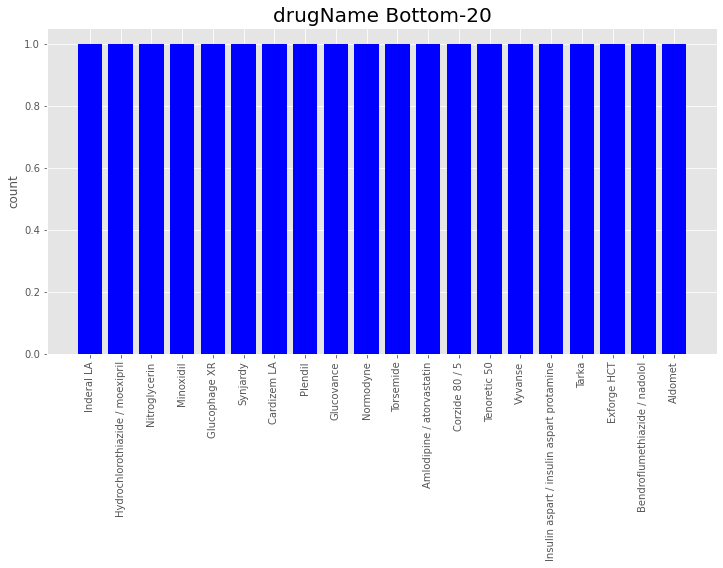

In [20]:
#plot a bargraph to check rarest 20 drugName
plt.figure(figsize=(12,6))
drugName_bottom = df['drugName'].value_counts(ascending = False).tail(20)

plt.bar(drugName_bottom.index,drugName_bottom.values,color='blue')
plt.title('drugName Bottom-20',fontsize = 20)
plt.xticks(rotation=90)
plt.ylabel('count')
plt.show()

In [21]:
# print ratings distribution
ratings_ = df['rating'].value_counts().sort_values(ascending=False).reset_index().\
                    rename(columns = {'index' :'rating', 'rating' : 'counts'})
ratings_['percent'] = 100 * (ratings_['counts']/df.shape[0])
print(ratings_)

   rating  counts    percent
0    10.0    3763  26.986517
1     9.0    2468  17.699369
2     1.0    1802  12.923121
3     8.0    1795  12.872920
4     7.0     995   7.135686
5     5.0     756   5.421687
6     6.0     680   4.876649
7     2.0     645   4.625645
8     3.0     582   4.173838
9     4.0     458   3.284567


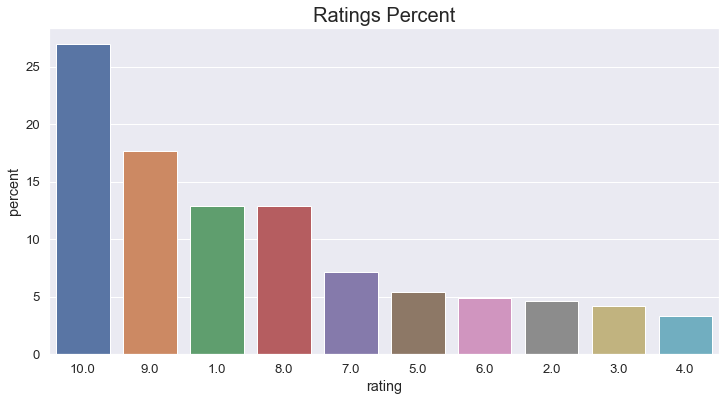

In [22]:
# plot ratings distribution 
sns.set(font_scale = 1.2, style = 'darkgrid')
plt.rcParams['figure.figsize'] = [12, 6]
sns.barplot(x = ratings_['rating'], y = ratings_['percent'],order = ratings_['rating'])
plt.title('Ratings Percent',fontsize=20)
plt.show()

In [23]:
# Let's check the number of drugs/condition
df.groupby('condition')['drugName'].nunique().sort_values(ascending=False).head(20)

condition
high blood pressure    140
depression             105
diabetes, type 2        89
Name: drugName, dtype: int64

In [24]:
# after removing the noise, let's check the shape
df.shape[0]

13944

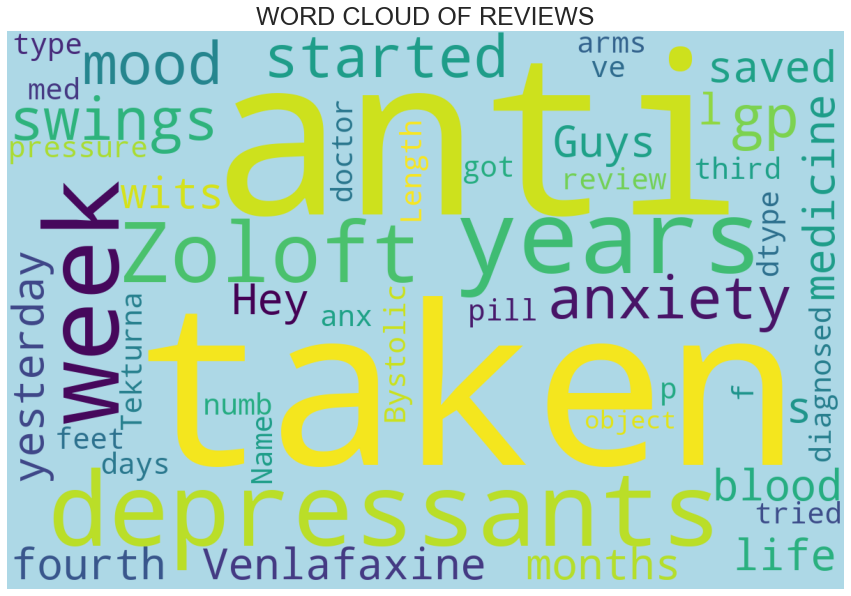

In [25]:
# let's see the words cloud for the reviews 

# most popular drugs

from wordcloud import WordCloud
from wordcloud import STOPWORDS

stopwords = set(STOPWORDS)

wordcloud = WordCloud(background_color = 'lightblue', stopwords = stopwords, width = 1200, height = 800).generate(str(df['review']))

plt.rcParams['figure.figsize'] = (15, 15)
plt.title('WORD CLOUD OF REVIEWS', fontsize = 25)
print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

# text processing

In [26]:
# Convert the condition column to lowercase
df['condition'] = df['condition'].str.lower()

# Select rows where the condition is depression, high blood pressure, or type 2 diabetes
condition_list = ['depression', 'high blood pressure', 'diabetes, type 2']
df_selected = df[df['condition'].isin(condition_list)]

# Save the resulting dataframe to a CSV file
df_selected.to_csv('drug_data.csv', index=False)

In [27]:
#check first three reviews
for i in df['review'][0:20]:
    print(i,'\n')

"I have taken anti-depressants for years, with some improvement but mostly moderate to severe side affects, which makes me go off them.

I only take Cymbalta now mostly for pain.

When I began Deplin, I noticed a major improvement overnight. More energy, better disposition, and no sinking to the low lows of major depression. I have been taking it for about 3 months now and feel like a normal person for the first time ever. Best thing, no side effects." 

"1 week on Zoloft for anxiety and mood swings. I take 50mg in the mornings with my breakfast. Nausea on day one  but that subsided as the week went on.  I get the jitters about 2 hrs after taking it followed by yawning. I feel much better though and less angry/stressed." 

"my gp started me on Venlafaxine yesterday to help with depression and the change,a hour after taking them i was feeling very sick couldn,t stomach food or fluids, thought keep it up as she told me they did come with some side effects which would get better,took anot

In [28]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from contractions import contractions_dict


# Define the process_review function
def process_review(review):
    # Remove hashtags
    review = review.replace('#', '')
    
    # Expand contractions
    words = review.split()
    words = [contractions_dict[word] if word in contractions_dict else word for word in words]
    review = ' '.join(words)
    
    # Tokenize the text
    tokens = word_tokenize(review)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if not token in stop_words]
    
    # Remove punctuation
    tokens = [token for token in tokens if token.isalpha()]
    
    # Return the processed tokens
    return ' '.join(tokens)

# Clean the drug reviews
df['processed_review'] = df['review'].apply(process_review)


In [29]:
import nltk
nltk.download('wordnet')

[nltk_data] Error loading wordnet: <urlopen error [WinError 10060] A
[nltk_data]     connection attempt failed because the connected party
[nltk_data]     did not properly respond after a period of time, or
[nltk_data]     established connection failed because connected host
[nltk_data]     has failed to respond>


False

In [30]:
# Apply the process_review function to the review column
df['processed_review'] = df['review'].apply(process_review)
df['condition'] = df['condition'].apply(process_review)
df['drugName'] = df['drugName'].apply(process_review)

# Print the first 10 processed reviews
print(df['processed_review'].head(10))


0    I taken years improvement mostly moderate seve...
1    week Zoloft anxiety mood swings I take morning...
2    gp started Venlafaxine yesterday help depressi...
3    Hey Guys It months since last post I wanted gi...
4    This medicine saved life I wits end ready give...
5    Started taking I slept well night awoke early ...
6    Intake Effexor XR mg lorazepam depression anxi...
7    My blood pressure around Doctor prescribed Azo...
8    This medication amazing After days extremely s...
9    I recently referred endocrinologist started Tr...
Name: processed_review, dtype: object


In [31]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [32]:
import pandas as pd

# Create a new column for sentiment
df['Sentiment'] = ''

# Assign sentiment based on rating
df.loc[df['rating'] < 3, 'Sentiment'] = 'negative'
df.loc[df['rating'] > 7, 'Sentiment'] = 'positive'
df.loc[(df['rating'] >= 3) & (df['rating'] <= 7), 'Sentiment'] = 'neutral'

# Print the updated dataset with sentiment column
print(df)


       UniqueID      drugName            condition  \
0         75612                         depression   
1         96233    Sertraline           depression   
2        121333   Venlafaxine           depression   
3        156544   Dulaglutide        diabetes type   
4        131909    Effexor XR           depression   
...         ...           ...                  ...   
13939    198130    Metoprolol  high blood pressure   
13940     34443      Bystolic  high blood pressure   
13941     86533      Invokana        diabetes type   
13942     93069  Vortioxetine           depression   
13943    103458      Tekturna  high blood pressure   

                                                  review  rating       date  \
0      "I have taken anti-depressants for years, with...    10.0 2017-03-09   
1      "1 week on Zoloft for anxiety and mood swings....     8.0 2011-05-07   
2      "my gp started me on Venlafaxine yesterday to ...     4.0 2016-04-27   
3      "Hey Guys,  It&#039;s been 4

In [33]:
# Remove irrelevant columns
df = df.drop(columns=['UniqueID', 'date', 'usefulCount' ,'review'] , axis=1)

In [34]:
df.head(50)

,drugName,condition,rating,processed_review,Sentiment
0,,depression,10.0,I taken years improvement mostly moderate seve...,positive
1,Sertraline,depression,8.0,week Zoloft anxiety mood swings I take morning...,positive
2,Venlafaxine,depression,4.0,gp started Venlafaxine yesterday help depressi...,neutral
3,Dulaglutide,diabetes type,10.0,Hey Guys It months since last post I wanted gi...,positive
4,Effexor XR,depression,10.0,This medicine saved life I wits end ready give...,positive
5,Wellbutrin,depression,4.0,Started taking I slept well night awoke early ...,neutral
6,Aripiprazole,depression,4.0,Intake Effexor XR mg lorazepam depression anxi...,neutral
7,Amlodipine olmesartan,high blood pressure,10.0,My blood pressure around Doctor prescribed Azo...,positive
8,Desvenlafaxine,depression,10.0,This medication amazing After days extremely s...,positive
9,Dulaglutide,diabetes type,9.0,I recently referred endocrinologist started Tr...,positive


In [35]:
import pandas as pd
from sklearn.model_selection import train_test_split


# define features and target variable
X = df[['drugName', 'condition', 'processed_review']]
y = df['Sentiment']


In [36]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# One-hot encode the categorical features
ohe = OneHotEncoder()
X = ohe.fit_transform(X)

# Label encode the target variable
le = LabelEncoder()
y  = le.fit_transform(y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



In [37]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

# train the Naive Bayes model
nb = MultinomialNB()
nb.fit(X_train, y_train)

# make predictions on the testing set
y_pred = nb.predict(X_test)

# evaluate the performance of the model
from sklearn.metrics import accuracy_score, classification_report
print("Accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy:  0.5822179732313576
              precision    recall  f1-score   support

           0       0.58      0.04      0.07       744
           1       0.62      0.08      0.14      1077
           2       0.58      0.98      0.73      2363

    accuracy                           0.58      4184
   macro avg       0.59      0.37      0.32      4184
weighted avg       0.59      0.58      0.46      4184



In [38]:
# import required libraries
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# create xgboost model
model = xgb.XGBClassifier()

# fit the model to the training data
model.fit(X_train, y_train)

# make predictions on test data
y_pred = model.predict(X_test)

# calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)


Accuracy: 0.5659655831739961


In [39]:

# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score



# Create an SVM object and fit it to the training data
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_model.predict(X_test)

# Calculate the accuracy score of the model
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy score
print("Accuracy:", accuracy)



Accuracy: 0.7186902485659655


# save Model


In [40]:
import pickle

In [41]:
# saving the model 
import pickle 
pickle_out = open("model.pkl", mode = "wb") 
pickle.dump(svm_model, pickle_out) 
pickle_out.close()

In [42]:
load_model = pickle.load(open('model.sav','rb'))